# Classifying Palmer Penguins
### 2/22/2024

In [1]:
# Accessing the training data
import pandas as pd

train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

In [2]:
train.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0809,31,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N63A1,Yes,11/24/08,40.9,16.6,187.0,3200.0,FEMALE,9.08458,-24.54903,NaN
1,PAL0809,41,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N74A1,Yes,11/24/08,49.0,19.5,210.0,3950.0,MALE,9.53262,-24.66867,NaN
2,PAL0708,4,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N32A2,Yes,11/27/07,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,NaN
3,PAL0708,15,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N38A1,Yes,12/3/07,45.8,14.6,210.0,4200.0,FEMALE,7.79958,-25.62618,NaN
4,PAL0809,34,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N65A2,Yes,11/24/08,51.0,18.8,203.0,4100.0,MALE,9.23196,-24.17282,NaN


### 1. Explore 
##### Construct two interesting **displayed figure** and at least one interesting displayed summary table. Include discussino of figures and table- explain what is learned about the data from the products


### Starting with Data Preparation:

##### Converting "Sex" and "Island" columns into binary values. 

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

##### Next, in variable selection, to narrow the options down to just three variables, one thing that can be done is remove variables with low variance. Choosing to set a threshold at 80%, for example,  removes variables where 80% or more observations share the same variable value.

In [4]:
from sklearn.feature_selection import VarianceThreshold
thresh = VarianceThreshold(threshold = (0.8*(1-0.8)))
highVar = thresh.fit_transform(X_train)
highVar.shape, X_train.shape

((256, 10), (256, 14))

##### Removing features with less than 20% variance got rid of 4 out of 15 variables. As variance increases, I am interested in when and where the msot variables no longer make the threshold

In [5]:
thresh1 = VarianceThreshold(threshold = (0.5*(1-0.5)))
highVar1 = thresh1.fit_transform(X_train)
highVar1.shape, X_train.shape

((256, 6), (256, 14))

##### At around 50% variance, the majority of variables no longer reach the variance threshold. Cool! I will probably use a threshold around 30% variance

In [6]:
thresh30 = VarianceThreshold(threshold = (0.7*(1-0.7)))
highVar30 = thresh30.fit_transform(X_train)
highVar30.shape, X_train.shape

((256, 10), (256, 14))

##### Next, using Univariate feature selection, we can use an F-test to retreive the three best features for the dataset, estimating the degree of linear dependency between the variables.

In [7]:
#from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
#X_train, y_train = load_iris(return_X_y = True)
#X_train.shape
# Create and fit selector
X_new = SelectKBest(f_classif, k = 3)
X_new.fit(X_train, y_train)




/Users/breannaguo/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/breannaguo/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


SelectKBest(k=3)

##### Now that we have the 3 best features, we have to create a new dataframe with the columns we want in it

In [8]:
# Get columns to keep and create new dataframe
cols = X_new.get_support(indices = True)
X_train_new = X_train.iloc[:,cols]

X_train_new.head()


,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm)
0,40.9,16.6,187.0
1,49.0,19.5,210.0
2,50.0,15.2,218.0
3,45.8,14.6,210.0
4,51.0,18.8,203.0


##### I've learned that the top 3 variables this method will pick are 3 quantitative variables. One of the restrictions of this assignment are that one of the three variables used must be qualitative. So in the next run, I will split the columns into quantitative and qualitative, and pick the top quantitative variables and the top qualitative variables

### Running it all again with more variables and separating quantitative and qualitative variables

In [13]:
# redefining the prepare_data function to remove the Unnamed: 0 column. Also, including the egg laying and region data
def prepare_data1(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Comments"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  # assigning dummy values the "int" data type
  df = pd.get_dummies(df,dtype = int)
  return df, y

# recreating the training data
X_train1, y_train1 = prepare_data1(train)

#discerining the quantitative and qualitative variables
# dummy variables represent qualitative values. Since they are "int" data types, 
# and other quantiative variables are "float", they can be separated
all_qual_cols = X_train1.select_dtypes(exclude=float)
all_quant_cols = X_train1.select_dtypes(include=float)

X_train1[all_qual_cols.columns]


,Region_Anvers,Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Date Egg_11/10/07,Date Egg_11/10/08,Date Egg_11/10/09,...,Date Egg_11/6/08,Date Egg_11/7/08,Date Egg_11/8/08,Date Egg_11/9/07,Date Egg_11/9/08,Date Egg_11/9/09,Date Egg_12/1/09,Date Egg_12/3/07,Sex_FEMALE,Sex_MALE
0,1,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,1,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,1,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
271,1,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
272,1,0,1,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
273,1,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


There are significantly more qualitative variables than quantitative, but a lot of them are a binary regarding whether or not the observed penguin laid eggs on a given date.

##### Now that I have quantitative and qualitiative variables split, I will proceed with the following feature chosing methods having them separated.

Note: The "Date Egg" and "Island" columns are currently stored wide. If I have time, I should come back and pivot them to be long.

In [14]:

# removing low threshold variance variables from the qual columns
thresh30ql = VarianceThreshold(threshold = (0.7*(1-0.7)))
highVar30ql = thresh30ql.fit_transform(X_train1[all_qual_cols.columns])
# using univariate feature selection, using F-tests to select the best qual feature
X_newql = SelectKBest(f_classif, k = 3)
X_newql.fit(X_train1[all_qual_cols.columns], y_train1)

# removing low threshold variance variables from the quant columns
thresh30qt = VarianceThreshold(threshold = (0.7*(1-0.7)))
highVar30qt = thresh30qt.fit_transform(X_train1[all_quant_cols.columns])
# using univariate feature selection, using F-tests to select the 2 best quant features
X_newqt = SelectKBest(f_classif, k = 3)
X_newqt.fit(X_train1[all_quant_cols.columns], y_train1)

# creating a new dataframe with the selected qualitative feature
cols = X_newql.get_support(indices = True)
X_train_newql = X_train1[all_qual_cols.columns].iloc[:,cols]
# adding an ID column to data frame to add the selected quant features
X_train_newql['ID'] = X_train1.index

# creating a new dataframe with the selected qualitative feature
cols = X_newqt.get_support(indices = True)
X_train_newqt = X_train1[all_quant_cols.columns].iloc[:,cols]
# adding an ID column
X_train_newqt['ID'] = X_train1.index

# merging best qualitative and quantitative variabels into one data set
X_train_new_merged = pd.merge(X_train_newql, X_train_newqt, on = 'ID')
# removing the ID column
X_train_new_merged = X_train_new_merged.drop(['ID'], axis = 1)

# viewing the new dataframe
X_train_new_merged.head()

/Users/breannaguo/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 4] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/breannaguo/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


,Island_Biscoe,Island_Dream,Island_Torgersen,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm)
0,0,1,0,40.9,16.6,187.0
1,0,1,0,49.0,19.5,210.0
2,1,0,0,50.0,15.2,218.0
3,1,0,0,45.8,14.6,210.0
4,0,1,0,51.0,18.8,203.0


##### After using both quantiative and qualitative features, it appears that the penguins island, their culmen size, and Flipper Length (mm) are the "best" features as determined by the F-Test. With these variables, I want to visualize them to see if there are any patterns

<Axes: xlabel='Culmen Length (mm)', ylabel='Flipper Length (mm)'>

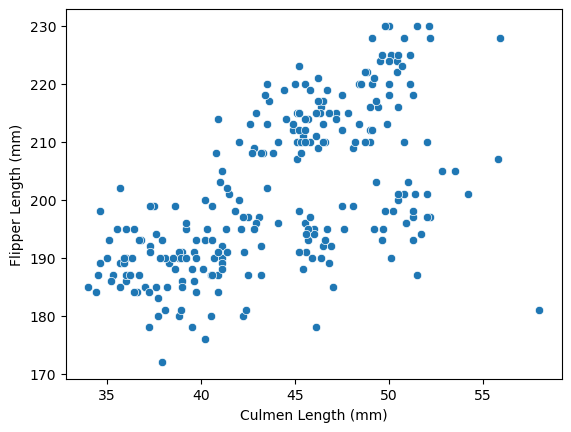

In [15]:
import seaborn as sns
sns.scatterplot(X_train_new_merged, x = 'Culmen Length (mm)', y = 'Flipper Length (mm)')

There seems to be a positive trend, as culmen length increases, so does flipper length. There also appear to be outliers, which will make training and testing more interesting.

<Axes: xlabel='Island_Biscoe', ylabel='Culmen Depth (mm)'>

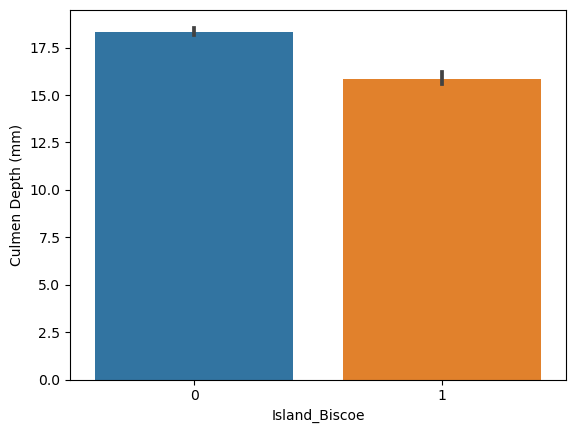

In [16]:
sns.barplot(X_train_new_merged, x = 'Island_Biscoe', y = 'Culmen Depth (mm)')

Of the penguins that live on the island and those that don't, the culmen length is not significantly different

<Axes: xlabel='Island_Biscoe', ylabel='Flipper Length (mm)'>

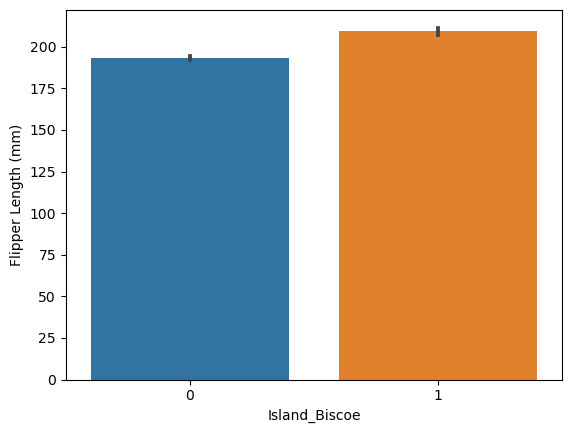

In [17]:
sns.barplot(X_train_new_merged, x = 'Island_Biscoe', y = 'Flipper Length (mm)')

Of the penguins that live on and off the island, there is a significant difference in their flipper length.

Trying another method to see if I get similar variable selection

from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
X_train1, y_train1 = load_iris(return_X__y=True)
X_train1.shape
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train1, y_train1)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_train1)
X_new.shape

### 2. Model
##### Find *three features* of the data and a model trained on the features that achieve 100% testing accuracy. Must use a reproducible process to obtain the three features (code up a search to obtain them). One features qualitative, two quantitative

I think if I learned anything taking Stat learning with Professor Lyford, it is to be very suspicious if any model tests with 100% accuracy. Maybe I'm just not that good at making models, but I have never made a model with 100% testing accuracy without cheating. Either there's a unique identifier, a tuning parameter of the model is off, or it's just incredibly overfit. 

In [18]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(X_train_new_merged, y_train1)
acc = LR.score(X_train_new_merged, y_train1)

acc

/Users/breannaguo/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.99609375

It appear that using these three variables, chosen by using an F-test, the linear regression has a 99% accuracy. Narrowing down the variables from 64 to just 3 to ge 99% classification accuracy on the training data is not bad!

In [19]:
from sklearn.model_selection import cross_val_score
cv_scores_LR = cross_val_score(LR, X_train_new_merged, y_train1, cv = 5)
cv_scores_LR.mean()

/Users/breannaguo/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/breannaguo/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

0.9883861236802414

### Time to run it on the testing data and see how the model does

In [20]:
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)


cols = X_train_new_merged.columns

X_test, y_test = prepare_data(test)
LR.score(X_test[cols], y_test)

1.0

While running the model on training data does not have 100% accuracy, the model gets 100% accuracy on the testing data. I won't think too hard into the difference in accuracy here. It does make me think that there is maybe an outlier in my training data that doesn't occur in the testing data

### Graphing the decision regions

In [21]:
X_train_new_merged.head()

,Island_Biscoe,Island_Dream,Island_Torgersen,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm)
0,0,1,0,40.9,16.6,187.0
1,0,1,0,49.0,19.5,210.0
2,1,0,0,50.0,15.2,218.0
3,1,0,0,45.8,14.6,210.0
4,0,1,0,51.0,18.8,203.0


In [22]:
from matplotlib import pyplot as plt
import numpy as np

from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[3]]
    x1 = X[X.columns[4]]
    x2 = X[X.columns[5]]
    qual_features = X.columns[:3]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    grid_z = np.linspace(x2.min(),x2.max(),501)
    xx, yy, zz = np.meshgrid(grid_x, grid_y, grid_z)
    
    XX = xx.ravel()
    YY = yy.ravel()
    ZZ = zz.ravel()

    for i in range(len(qual_features)):
      XYZ = pd.DataFrame({
          X.columns[3] : XX,
          X.columns[4] : YY,
          X.columns[5] : ZZ
      })

      for j in qual_features:
        XYZ[j] = 0

      XYZ[qual_features[i]] = 1

      p = model.predict(XYZ)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, zz, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], x2[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


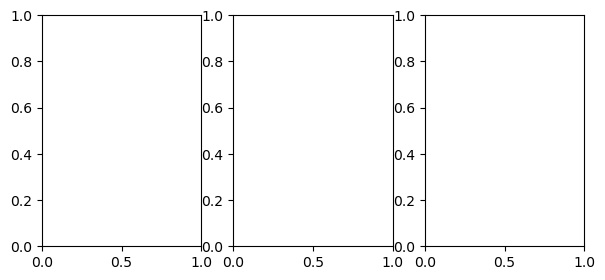

In [ ]:
plot_regions(LR, X_train_new_merged, y_train1)

### 3. Evaluate:
